In [1]:
import numpy as np

import pandas as pd
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import seaborn as sns

from sklearn.metrics import mean_squared_error

In [2]:
def tsplot(y, 
           lags=None, 
           title='', 
           figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [3]:
def ARIMA_plot_ki(series, 
               order,
               train_size_percent,
               scale=1):
    
    # Credit to Fong King Ian for providing this code

    # convert Series to DataFrame
    # remove duplicated rows except for most recent, convert to daily freq, fil blanks with prev observation
    X = series.rename("actual").to_frame() 
    X = X.loc[~X.index.duplicated(keep='last')].asfreq('d', 'ffill')
    
    # determine where the training set ends and the test set starts
    size = int(len(X) * train_size_percent)
    first_test_index = X.index[size]
        
    # forecast out-of-sample value using ARIMA
    for t in X[X.index >= first_test_index].index.tolist():
        # fit model with 'actual' values up to and excluding time t
        model = ARIMA(X[X.index < t]['actual'].values, order)
        model_fit = model.fit(disp=0)
        
        # forecast returns 3 arrays: 
        # out-of-sample forecast value, std error of the forecast and 
        # 2d array of the confidence interval for the forecast 
        
        output = model_fit.forecast()
        X.loc[t, 'predictions'] = output[0]  # output[0] contains forecast value
#        print('predicted = %f, expected = %f' % (output[0], X.at[t, 'actual']))
    
    # aligning predictions with correct time periods, removing rows without predictions
    X['predictions'] = X['predictions'].shift(-1)
    X.dropna(inplace = True)
    
    # MSE
    error = mean_squared_error(X['actual'].values, X['predictions'].values)
    print('Test MSE: %.3f' % error)
    
    # Scale to avoid exceeding maximum margin of plots
    test_scaled = X['actual'].values / scale
    predictions_scaled = X['predictions'].values / scale

    # plot
    plt.plot(test_scaled, color='blue', label='true values')
    plt.plot(predictions_scaled, color='red', label=f'estimated ARIMA{order}')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

======================================================================================================================

# Examples of Financial Time Series

In [5]:
# Download Bitcoin's, Amazon's and Apple's historical price from Yahoo Finance as csv files
BitCoin = read_csv('BTC-USD.csv', 
                    header = 0, 
                    parse_dates = [0],  
                    index_col = 0, 
                    squeeze = True, 
                    date_parser = parser)

Amazon = read_csv('amzn.csv',  
                  header = 0, 
                  parse_dates = [0],
                  index_col = 0,
                  squeeze = True,
                 date_parser = parser)

AAPL = read_csv('AAPL.csv',
                  header = 0, 
                  parse_dates = [0],  
                  index_col = 0, 
                  squeeze = True, 
                  date_parser = parser)

In [6]:
BitCoin.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-18,7383.390137,7563.700195,7289.899902,7477.500000,7477.500000,522544440
2018-07-19,7477.100098,7676.549805,7279.339844,7333.930176,7333.930176,603034414
2018-07-20,7333.930176,7453.069824,7220.370117,7405.399902,7405.399902,297440355
2018-07-21,7405.399902,7569.279785,7345.250000,7398.640137,7398.640137,355565264
2018-07-22,7398.640137,7798.589844,7376.660156,7718.000000,7718.000000,745533303


In [7]:
BitCoin.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2018-07-18 to 2019-07-19
Data columns (total 6 columns):
Open         366 non-null float64
High         366 non-null float64
Low          366 non-null float64
Close        366 non-null float64
Adj Close    366 non-null float64
Volume       366 non-null int64
dtypes: float64(5), int64(1)
memory usage: 20.0 KB


In [8]:
Amazon.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-20,1825.010010,1834.839966,1810.060059,1813.699951,1813.699951,3884400
2018-07-23,1812.209961,1819.000000,1769.989990,1802.000000,1802.000000,3888500
2018-07-24,1829.010010,1840.000000,1809.380005,1829.239990,1829.239990,4278700
2018-07-25,1829.300049,1863.839966,1822.640015,1863.609985,1863.609985,3738200
2018-07-26,1839.000000,1844.680054,1804.500000,1808.000000,1808.000000,9924400


In [9]:
Amazon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-07-20 to 2019-07-19
Data columns (total 6 columns):
Open         251 non-null float64
High         251 non-null float64
Low          251 non-null float64
Close        251 non-null float64
Adj Close    251 non-null float64
Volume       251 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [10]:
AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-20,191.779999,192.429993,190.169998,191.440002,188.569595,20676200
2018-07-23,190.679993,191.960007,189.559998,191.610001,188.737030,15989400
2018-07-24,192.449997,193.660004,192.050003,193.000000,190.106216,18697900
2018-07-25,193.059998,194.850006,192.429993,194.820007,191.898926,16709900
2018-07-26,194.610001,195.960007,193.610001,194.210007,191.298080,19076000


In [11]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-07-20 to 2019-07-19
Data columns (total 6 columns):
Open         251 non-null float64
High         251 non-null float64
Low          251 non-null float64
Close        251 non-null float64
Adj Close    251 non-null float64
Volume       251 non-null int64
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


(<matplotlib.axes._subplots.AxesSubplot at 0x11c8d6748>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ca7d048>)

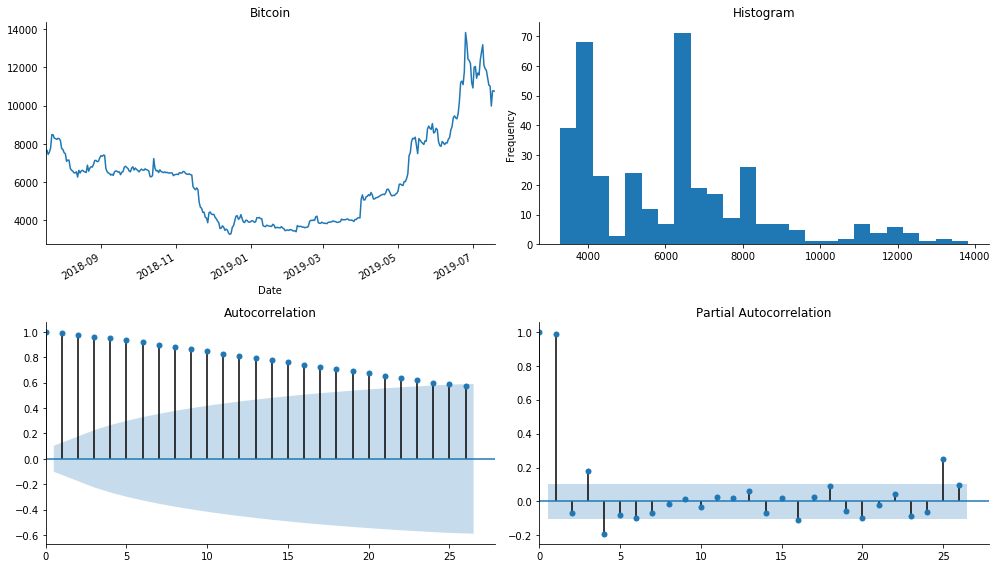

In [12]:
tsplot(BitCoin['High'], title='Bitcoin')

(<matplotlib.axes._subplots.AxesSubplot at 0x11ee791d0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f193c18>)

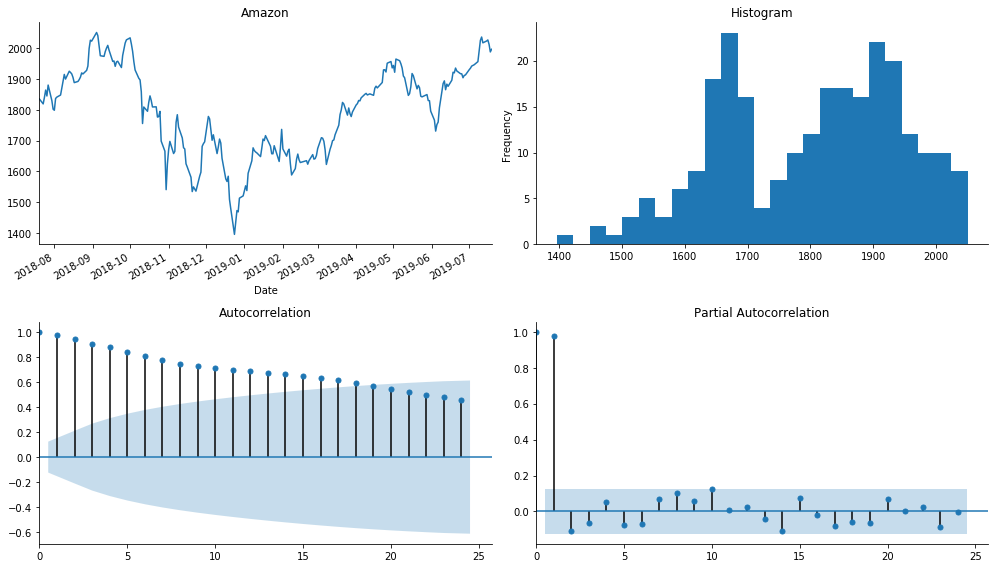

In [13]:
tsplot(Amazon['High'], title='Amazon')

(<matplotlib.axes._subplots.AxesSubplot at 0x11f2e35c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f592048>)

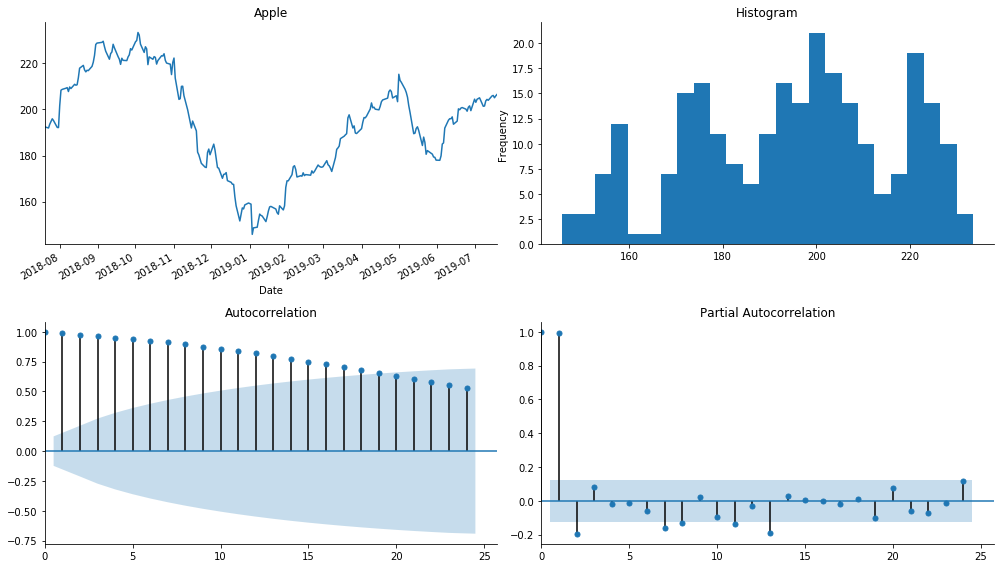

In [14]:
tsplot(AAPL['High'], title='Apple')

======================================================================================================================

# Forecasting

Test MSE: 39495.733


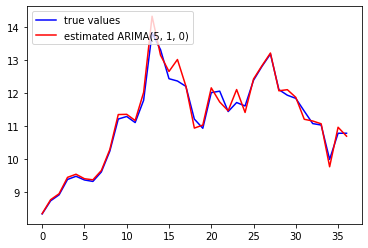

In [15]:
ARIMA_plot_ki(series = BitCoin['High'], 
              order = (5,1,0), 
              train_size_percent = 0.9, 
              scale = 1000)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Test MSE: 26.923


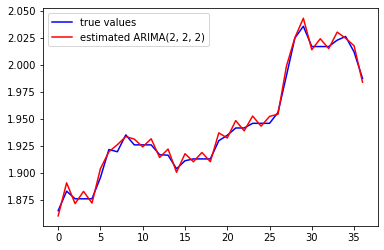

In [16]:
x = ARIMA_plot_ki(series = Amazon['High'], 
                  order = (2,2,2), 
                  train_size_percent = 0.9, 
                  scale = 1000)

Test MSE: 1.640


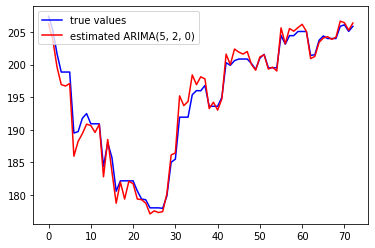

In [17]:
ARIMA_plot_ki(series = AAPL['High'], 
              order = (5,2,0), 
              train_size_percent = 0.8)